# **가설 검정**

## Member와 transaction data를 join해서 분석하기

 * member에는 city, bd (설명에 따르면, age와 같은 변수), gnedeer, registered_via, registration_init_time이 존재함
 * 이들 자료형에 맞도록 EDA를 진행

In [1]:
# 데이터 다루는 가장 기본적인 library
import pandas as pd
import numpy as np
import os, pickle

from bokeh.io import show, output_file, output_notebook
from bokeh.layouts import gridplot
from bokeh.models import ColumnDataSource, LinearColorMapper, BasicTicker, PrintfTickFormatter, ColorBar
from bokeh.palettes import Spectral5, Oranges9, Viridis256, grey, inferno
from bokeh.plotting import figure
from bokeh.sampledata.autompg import autompg as df
from bokeh.transform import factor_cmap
output_notebook()

Loading BokehJS ...

In [2]:
answer = pickle.load(open('../tut_data/answer.pkl', 'rb'))
member = pickle.load(open('../tut_data/member.pkl', 'rb'))
transaction_summary = pickle.load(open('../tut_data/transaction_summary.pkl', 'rb'))
log_summary = pickle.load(open('../tut_data/log_summary.pkl', 'rb'))

In [3]:
import sys
print('answer size = %.2f GB'%(sys.getsizeof(answer)/1024/1024/1024))
print('member size = %.2f GB'%(sys.getsizeof(member)/1024/1024/1024))
print('transaction_summary size = %.2f GB'%(sys.getsizeof(transaction_summary)/1024/1024/1024))
print('log_summary size = %.2f GB'%(sys.getsizeof(log_summary)/1024/1024/1024))


answer size = 0.10 GB
member size = 1.11 GB
transaction_summary size = 0.61 GB
log_summary size = 0.80 GB


In [4]:
print('answer size = {}'.format(answer.shape))
print('member size = {}'.format(member.shape))
print('transaction_summary size = {}'.format(transaction_summary.shape))
print('log_summary size = {}'.format(log_summary.shape))

answer size = (992931, 2)
member size = (6769473, 6)
transaction_summary size = (2363626, 23)
log_summary size = (5226369, 9)


## Merge dataset

In [5]:
dat_1 = pd.merge(answer, member, how = 'left', on = 'msno')
dat_1 = pd.merge(dat_1, log_summary, how = 'left', on = 'msno')
data = pd.merge(dat_1, transaction_summary, how = 'left', on = 'msno')

In [6]:
data.groupby(['is_churn']).count()['msno'].reset_index().rename(columns = {'msno': 'count'})

is_churn   count
0         0  929460
1         1   63471

In [7]:
_dat = data[(~np.isnan(data['bd'])) &  (~np.isnan(data['num_100_sum']))]

In [8]:
_dat.groupby(['is_churn']).count()['msno'].reset_index().rename(columns = {'msno': 'count'})

is_churn   count
0         0  812700
1         1   57143

$\Rightarrow$ Missing이 없는 값이 57143건 존재

|is_churn	| msno|
|:--:|:--:|
|0|929460|
|1|63471|

* Missing값을 없애는 게 맞는가? 데이터에 missing이 많은가가 하나의 기준.
* Missing값이 많으면, 하나의 코드로 처리

In [9]:
data.fillna(-1, inplace= True)

In [10]:
data.head()

msno  is_churn  city    bd  gender  \
0  waLDQMmcOu2jLDaV1ddDkgCrB/jl6sD66Xzs0Vqax1Y=         1  18.0  36.0  female   
1  QA7uiXy8vIbUSPOkCf9RwQ3FsT8jVq2OxDr8zqa7bRQ=         1  10.0  38.0    male   
2  fGwBva6hikQmTJzrbz/2Ezjm5Cth5jZUNvXigKK2AFA=         1  11.0  27.0  female   
3  mT5V8rEpa+8wuqi6x0DoVd3H5icMKkE9Prt49UlmK+4=         1  13.0  23.0  female   
4  XaPhtGLk/5UvvOYHcONTwsnH97P4eGECeq+BARGItRw=         1   3.0  27.0    male   

   registered_via  registration_init_time  date_count  num_25_sum  num_50_sum  \
0             9.0              20050406.0        26.0        51.0        16.0   
1             9.0              20050407.0       521.0       447.0       157.0   
2             9.0              20051016.0       237.0      1570.0       950.0   
3             9.0              20051102.0       721.0      7137.0      2386.0   
4             9.0              20051228.0       758.0      1389.0       714.0   

              ...               transaction_date_last  \
0             ...                          2017-01-07   
1             ...                          2017-02-24   
2             ...                          2017-01-12   
3             ...                          2016-01-06   
4             ...                          2017-01-28   

   transaction_date_nunique  membership_expire_date_first  \
0                         2                      20161107   
1                        23                      20150321   
2                        10                      20160303   
3                         2                      20160107   
4                         8                      20160216   

   membership_expire_date_last  membership_expire_date_nunique  \
0                     20170206                               2   
1                     20170321                              22   
2                     20170203                               9   
3                     20170220                               2   
4                     20170227                               8   

   is_cancel_nunique  transaction_cycle_delta_mean  \
0                  1                     68.000000   
1                  2                     34.318182   
2                  2                     38.333333   
3                  1                      2.000000   
4                  1                    108.142857   

   transaction_cycle_delta_std  transaction_cycle_delta_min  \
0                     0.000000                         68.0   
1                    15.875667                         16.0   
2                    30.512293                         12.0   
3                     0.000000                          2.0   
4                   151.258530                          3.0   

   transaction_cycle_delta_max  
0                         68.0  
1                         95.0  
2                        118.0  
3                          2.0  
4                        409.0  

[5 rows x 37 columns]

## Balance dataset

In [11]:
# Balance 1/0 answers
# Balance 1/0 answers
is_not_churn_idx = np.random.choice(data[data['is_churn'] == 0].index, size = 100000)
balanced_data = pd.concat([data[data['is_churn'] == 1], data.iloc[is_not_churn_idx]], axis= 0)
balanced_data.groupby(['is_churn']).count()[['msno']].reset_index().rename(columns = {'msno': 'count'})
y = balanced_data.is_churn
# https://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.drop.html
balanced_data.drop(['is_churn'], axis = 1, inplace = True)

## Train & Validation set
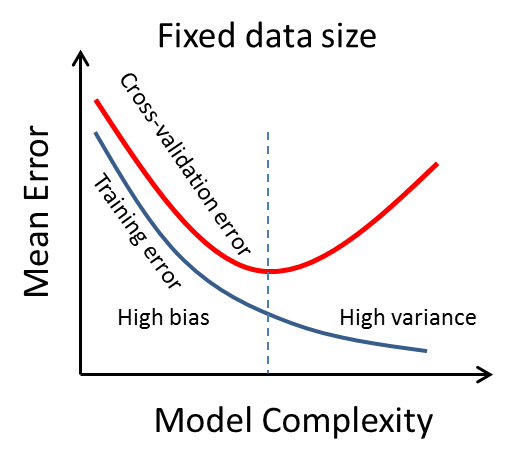

### train vs validation  set 나누기

In [12]:
from sklearn.model_selection import train_test_split
tr_x, va_x, tr_y, va_y = train_test_split(balanced_data, y, train_size = 0.7, random_state = 1234)

/opt/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Key만 따로 저장하기
* 나중에 개별 관측치에 대한 정보 확인할 때 중요함

In [13]:
tr_keys = tr_x[['msno']]
tr_x.drop(['msno'], axis = 1, inplace = True)

va_keys = va_x[['msno']]
va_x.drop(['msno'], axis = 1, inplace = True)

/opt/venv/lib/python3.6/site-packages/pandas/core/frame.py:3694: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


# **Model**

## AdaBoost

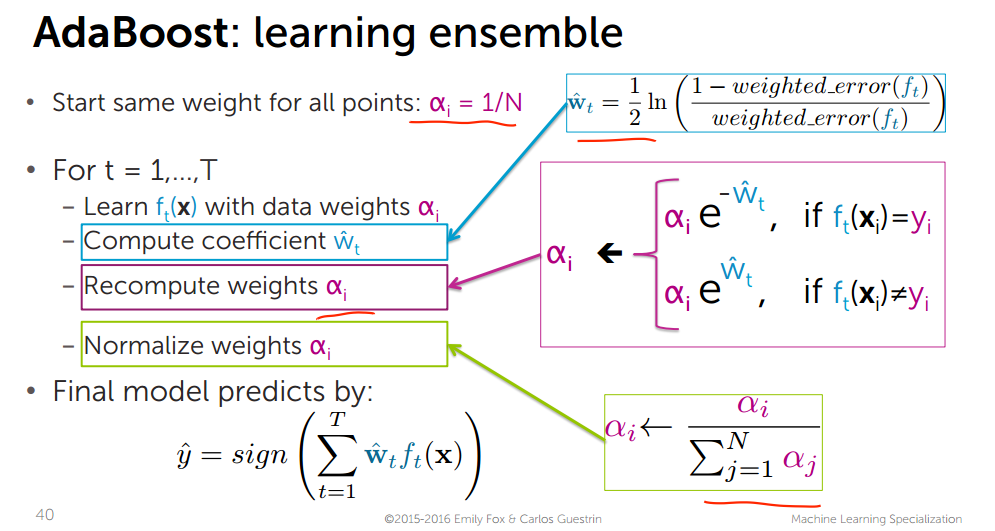

## XGBOOST
* numeric value만 받음
* RF에 비해 속도는 빠르나 overfitting이 잘되는 단점이 있다고 함

In [14]:
#https://xgboost.readthedocs.io/en/latest/python/python_intro.html
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
from sklearn import preprocessing 

In [15]:
tr_x_xgb = tr_x.drop(['transaction_date_first', 'transaction_date_last', 'registration_init_time', 'date_count'], axis = 1)
va_x_xgb = va_x.drop(['transaction_date_first', 'transaction_date_last', 'registration_init_time', 'date_count'], axis = 1)

### 변수를 numeric으로 전환

In [16]:
for f in tr_x_xgb.columns: 
    if tr_x_xgb[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(tr_x_xgb[f].values)) 
        tr_x_xgb[f] = lbl.transform(list(tr_x_xgb[f].values))
        
tr_x_xgb.fillna((-999), inplace=True) 
tr_x_xgb=np.array(tr_x_xgb) 
tr_x_xgb = tr_x_xgb.astype(float) 

for f in va_x_xgb.columns: 
    if va_x_xgb[f].dtype=='object': 
        lbl = preprocessing.LabelEncoder() 
        lbl.fit(list(va_x_xgb[f].values)) 
        va_x_xgb[f] = lbl.transform(list(va_x_xgb[f].values))
        
va_x_xgb.fillna((-999), inplace=True)
va_x_xgb=np.array(va_x_xgb) 
va_x_xgb = va_x_xgb.astype(float)
                   
dtrain = xgb.DMatrix(tr_x_xgb, label=tr_y) # , missing=-999.0
dval = xgb.DMatrix(va_x_xgb, label=va_y) # , missing=-999.0

###  Parameter 설정

In [17]:
param = {'max_depth': 2, 'eta': 1, 'silent': 1, 'objective': 'binary:logistic'}
param['nthread'] = 4
param['eval_metric'] = 'auc'
evallist = [(dval, 'eval'), (dtrain, 'train')]

###  Model fitting

In [19]:
num_round = 10
bst = xgb.train(param, dtrain, num_round, evallist)
if not os.path.exists:
    os.mkdir('../output')
bst.save_model('../output/0001.model')

[0]	eval-auc:0.935756	train-auc:0.936484
[1]	eval-auc:0.949302	train-auc:0.949805
[2]	eval-auc:0.958692	train-auc:0.959542
[3]	eval-auc:0.963165	train-auc:0.964328
[4]	eval-auc:0.965477	train-auc:0.966743
[5]	eval-auc:0.966783	train-auc:0.96789
[6]	eval-auc:0.967628	train-auc:0.968737
[7]	eval-auc:0.968361	train-auc:0.969438
[8]	eval-auc:0.969778	train-auc:0.970676
[9]	eval-auc:0.970868	train-auc:0.971725


In [20]:
pred_xg = bst.predict(dval)

### AUC plot
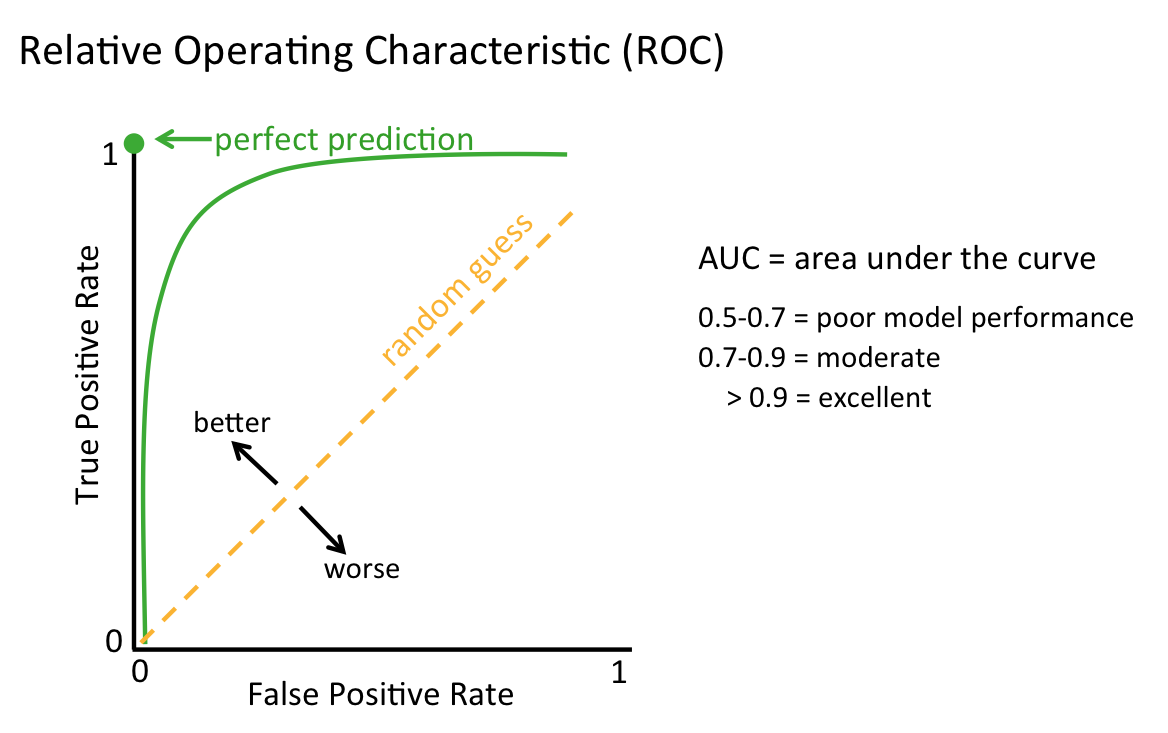

In [21]:
pred_xg

array([0.01204458, 0.04434127, 0.01276107, ..., 0.00495587, 0.5328484 ,
       0.99165994], dtype=float32)

In [22]:
auc = roc_auc_score(va_y, pred_xg, average = 'macro', sample_weight=None)

In [23]:
import matplotlib.pyplot as plt

fpr, tpr, _ = roc_curve(va_y,  pred_xg)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

<Figure size 640x480 with 1 Axes>

### Classification metric - Confusion matrix

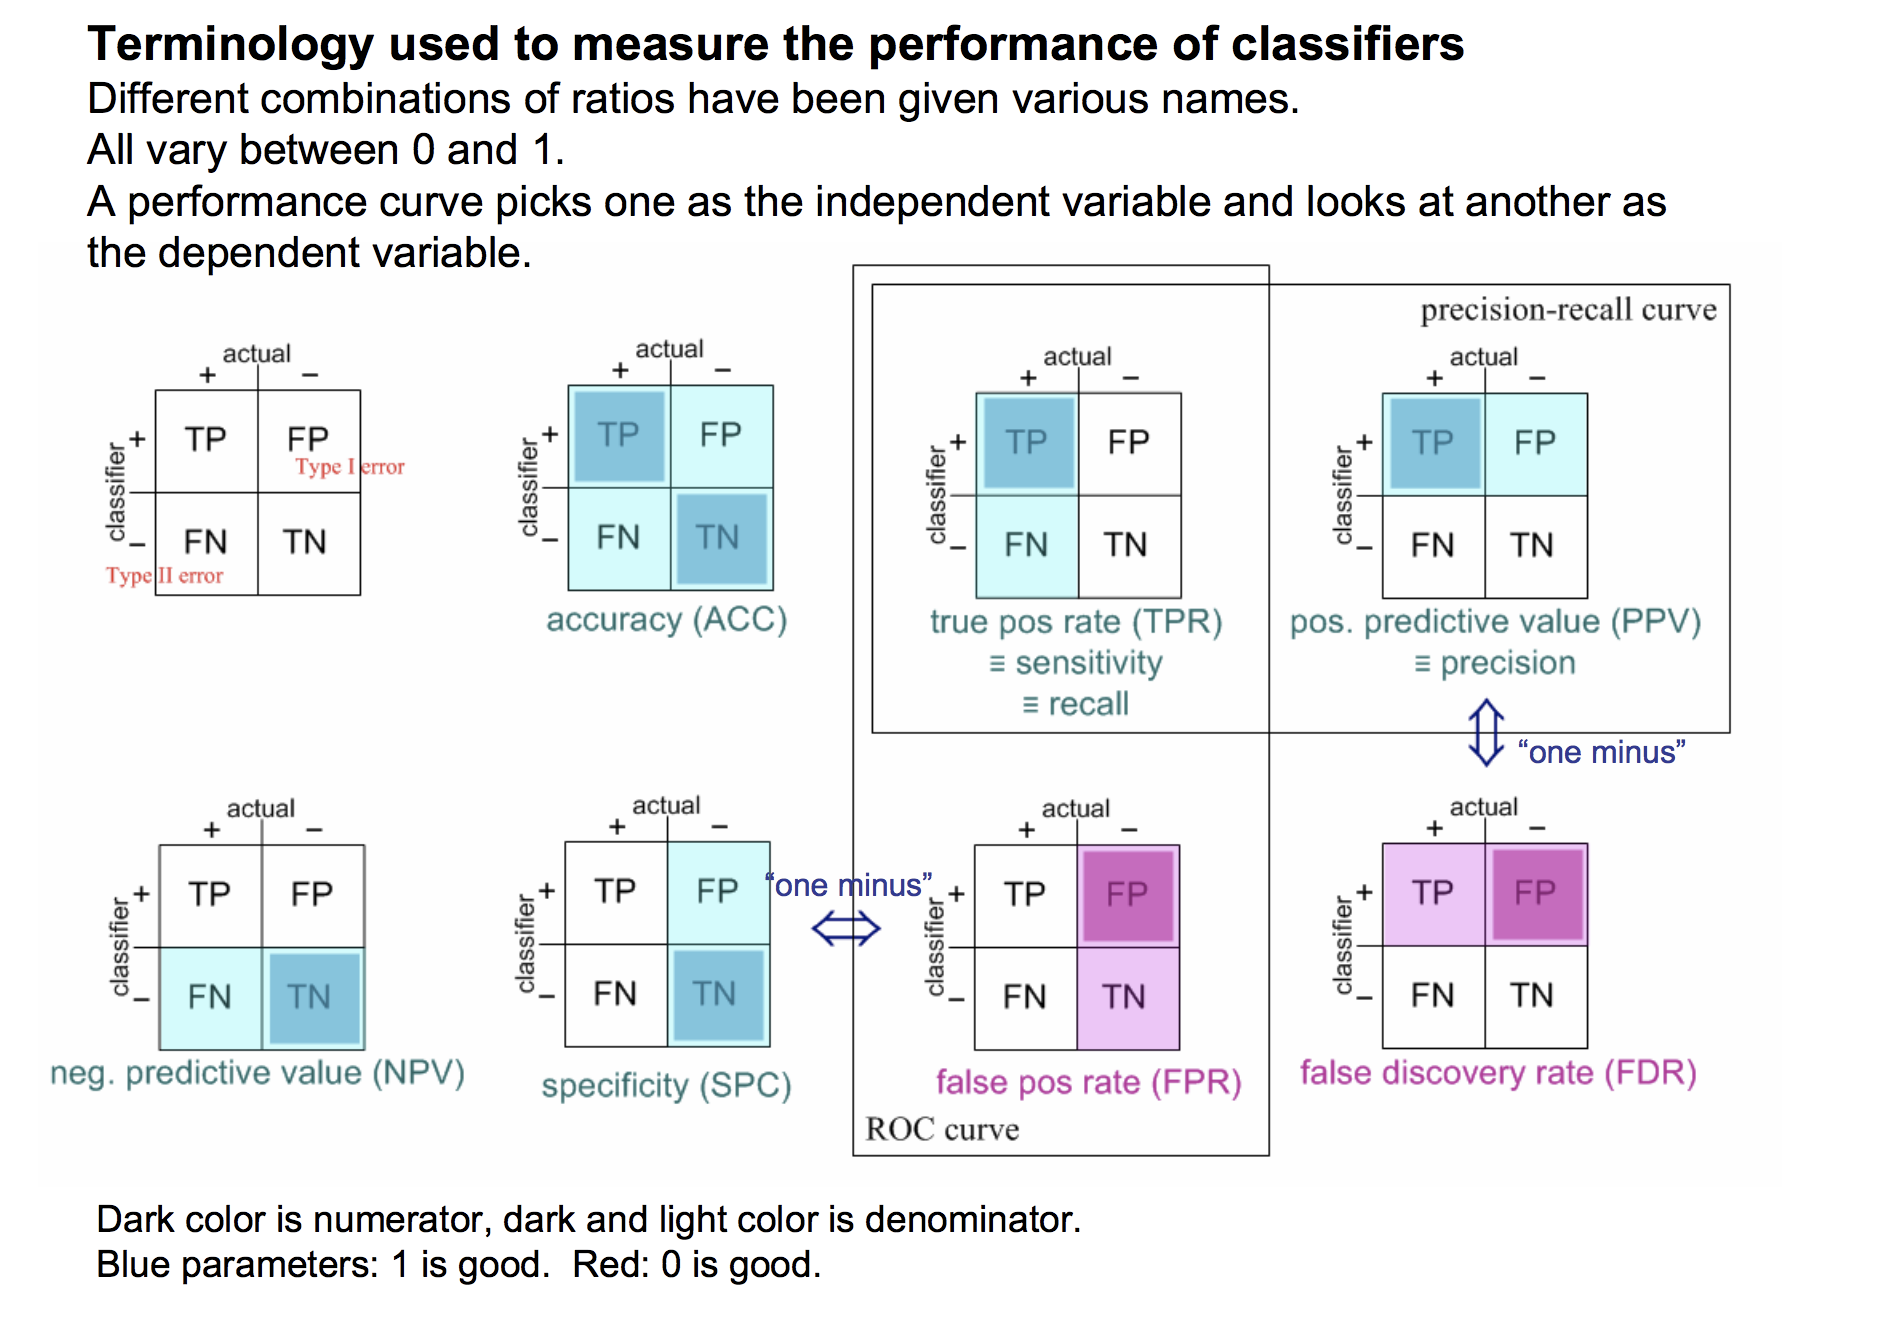

### Metrics: classification_report module

In [24]:
#출처: http://goodtogreate.tistory.com/entry/Confusion-Matrix-in-python [GOOD to GREAT]
from sklearn.metrics import classification_report
target_names = ['false', 'true']
print(classification_report(va_y, pred_xg > .5, target_names=target_names))

             precision    recall  f1-score   support

      false       0.93      0.94      0.94     29965
       true       0.91      0.89      0.90     19077

avg / total       0.92      0.92      0.92     49042



### Confusion matrix: pandas

In [25]:
pd.DataFrame([np.array(va_y), pred_xg])
# 출처: http://goodtogreate.tistory.com/entry/Confusion-Matrix-in-python [GOOD to GREAT]
pd.crosstab(np.array(va_y), pred_xg > .5, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted  False   True    All
True                          
0          28197   1768  29965
1           2130  16947  19077
All        30327  18715  49042

#### Double check

In [26]:
print('True Precision = {}'.format(16870/(16870 + 2207)))
print('False Precision = {}'.format(28297/(28297 + 1668)))

print('True Recall = {}'.format(16870/(16870 + 1668)))
print('False Recall = {}'.format(28297/(28297 + 2207)))

True Precision = 0.8843109503590711
False Precision = 0.9443350575671617
True Recall = 0.9100226561657137
False Recall = 0.9276488329399423


## CATBOOST
*  Categorical variable을 포함하는 경우 사용
* Overfitting 문제가 적고 속도가 아주 빠르다는 장점이 있음

In [27]:
def auc(m, train, test): 
    return (roc_auc_score(tr_y, m.predict_proba(train)[:,1]),
            roc_auc_score(va_y,  m.predict_proba(test)[:,1]))

In [28]:
import catboost as cb

In [29]:
tr_x_cb = tr_x.drop(['transaction_date_first', 'transaction_date_last', 'registration_init_time', 'membership_expire_date_first', 'membership_expire_date_last', 'membership_expire_date_nunique', 'date_count'], axis = 1)
va_x_cb = va_x.drop(['transaction_date_first', 'transaction_date_last', 'registration_init_time', 'membership_expire_date_first', 'membership_expire_date_last', 'membership_expire_date_nunique', 'date_count'], axis = 1)

### Null값 check

In [30]:
tr_x_cb.isnull().sum()

city                            0
bd                              0
gender                          0
registered_via                  0
num_25_sum                      0
num_50_sum                      0
num_75_sum                      0
num_985_sum                     0
num_100_sum                     0
num_unq_sum                     0
total_secs_sum                  0
plan_list_price_count           0
plan_list_price_nunique         0
plan_list_price_entropy         0
payment_method_id_nunique       0
payment_method_id_entropy       0
actual_amount_paid_mean         0
actual_amount_paid_count        0
actual_amount_paid_nunique      0
actual_amount_paid_entropy      0
is_auto_renew_count             0
is_auto_renew_nunique           0
transaction_date_nunique        0
is_cancel_nunique               0
transaction_cycle_delta_mean    0
transaction_cycle_delta_std     0
transaction_cycle_delta_min     0
transaction_cycle_delta_max     0
dtype: int64

### Decide categorical variables

In [31]:
pd.DataFrame(tr_x_cb.columns)

0
0                           city
1                             bd
2                         gender
3                 registered_via
4                     num_25_sum
5                     num_50_sum
6                     num_75_sum
7                    num_985_sum
8                    num_100_sum
9                    num_unq_sum
10                total_secs_sum
11         plan_list_price_count
12       plan_list_price_nunique
13       plan_list_price_entropy
14     payment_method_id_nunique
15     payment_method_id_entropy
16       actual_amount_paid_mean
17      actual_amount_paid_count
18    actual_amount_paid_nunique
19    actual_amount_paid_entropy
20           is_auto_renew_count
21         is_auto_renew_nunique
22      transaction_date_nunique
23             is_cancel_nunique
24  transaction_cycle_delta_mean
25   transaction_cycle_delta_std
26   transaction_cycle_delta_min
27   transaction_cycle_delta_max

In [32]:
categorical_features_indices = [0, 1, 2, 3]

In [33]:
clf = cb.CatBoostClassifier(eval_metric="AUC",one_hot_max_size=31, \
                            depth=10, iterations= 10, l2_leaf_reg= 9, learning_rate= 0.15)
%matplotlib inline
clf.fit(tr_x_cb, tr_y, cat_features = categorical_features_indices, eval_set=(va_x_cb, va_y), plot=True)

0:	test: 0.9375077	best: 0.9375077 (0)	total: 306ms	remaining: 2.76s
1:	test: 0.9425153	best: 0.9425153 (1)	total: 531ms	remaining: 2.12s


MetricVisualizer(data={'catboost_info': {'path': 'catboost_info', 'name': 'catboost_info', 'content': {'passed…

2:	test: 0.9451197	best: 0.9451197 (2)	total: 787ms	remaining: 1.84s
3:	test: 0.9465825	best: 0.9465825 (3)	total: 1000ms	remaining: 1.5s
4:	test: 0.9477251	best: 0.9477251 (4)	total: 1.2s	remaining: 1.2s
5:	test: 0.9489587	best: 0.9489587 (5)	total: 1.43s	remaining: 950ms
6:	test: 0.9506263	best: 0.9506263 (6)	total: 1.63s	remaining: 699ms
7:	test: 0.9512143	best: 0.9512143 (7)	total: 1.82s	remaining: 455ms
8:	test: 0.9520587	best: 0.9520587 (8)	total: 2.05s	remaining: 227ms
9:	test: 0.9527847	best: 0.9527847 (9)	total: 2.24s	remaining: 0us

bestTest = 0.9527847051
bestIteration = 9

Shrink model to first 10 iterations.


## Parameter search

In [34]:
from sklearn.model_selection import GridSearchCV

params = {'depth': [4, 7, 10],
          'learning_rate' : [0.03, 0.1, 0.15],
         'l2_leaf_reg': [1,4,9],
         'iterations': [10]}
clf_1 = cb.CatBoostClassifier()
cb_model = GridSearchCV(clf_1, params, scoring="roc_auc", cv = 3)
cb_model.fit(tr_x_cb, tr_y, cat_features = categorical_features_indices)

0:	learn: 0.6742581	total: 72.7ms	remaining: 654ms
1:	learn: 0.6565515	total: 148ms	remaining: 591ms
2:	learn: 0.6398762	total: 200ms	remaining: 467ms
3:	learn: 0.6235941	total: 261ms	remaining: 392ms
4:	learn: 0.6095770	total: 322ms	remaining: 322ms
5:	learn: 0.5962092	total: 373ms	remaining: 249ms
6:	learn: 0.5841774	total: 421ms	remaining: 180ms
7:	learn: 0.5736285	total: 479ms	remaining: 120ms
8:	learn: 0.5623508	total: 534ms	remaining: 59.3ms
9:	learn: 0.5530858	total: 580ms	remaining: 0us
0:	learn: 0.6742002	total: 81.2ms	remaining: 731ms
1:	learn: 0.6564310	total: 146ms	remaining: 584ms
2:	learn: 0.6399789	total: 205ms	remaining: 479ms
3:	learn: 0.6244607	total: 271ms	remaining: 407ms
4:	learn: 0.6047241	total: 324ms	remaining: 324ms
5:	learn: 0.5918121	total: 377ms	remaining: 252ms
6:	learn: 0.5800136	total: 443ms	remaining: 190ms
7:	learn: 0.5694860	total: 502ms	remaining: 125ms
8:	learn: 0.5590457	total: 560ms	remaining: 62.2ms
9:	learn: 0.5478450	total: 606ms	remaining: 0us


4:	learn: 0.4338130	total: 331ms	remaining: 331ms
5:	learn: 0.4102920	total: 392ms	remaining: 261ms
6:	learn: 0.3916604	total: 448ms	remaining: 192ms
7:	learn: 0.3825814	total: 504ms	remaining: 126ms
8:	learn: 0.3764167	total: 565ms	remaining: 62.7ms
9:	learn: 0.3650735	total: 622ms	remaining: 0us
0:	learn: 0.6075798	total: 83.8ms	remaining: 754ms
1:	learn: 0.5479448	total: 141ms	remaining: 564ms
2:	learn: 0.5099897	total: 215ms	remaining: 501ms
3:	learn: 0.4828461	total: 278ms	remaining: 416ms
4:	learn: 0.4462634	total: 336ms	remaining: 336ms
5:	learn: 0.4271213	total: 396ms	remaining: 264ms
6:	learn: 0.4081603	total: 456ms	remaining: 196ms
7:	learn: 0.3905243	total: 507ms	remaining: 127ms
8:	learn: 0.3791341	total: 564ms	remaining: 62.7ms
9:	learn: 0.3712366	total: 620ms	remaining: 0us
0:	learn: 0.6744551	total: 83.8ms	remaining: 754ms
1:	learn: 0.6567766	total: 144ms	remaining: 575ms
2:	learn: 0.6401438	total: 215ms	remaining: 502ms
3:	learn: 0.6248793	total: 278ms	remaining: 417ms


9:	learn: 0.3362927	total: 946ms	remaining: 0us
0:	learn: 0.5715821	total: 114ms	remaining: 1.02s
1:	learn: 0.4745253	total: 207ms	remaining: 827ms
2:	learn: 0.4149265	total: 302ms	remaining: 705ms
3:	learn: 0.3784714	total: 390ms	remaining: 586ms
4:	learn: 0.3572242	total: 485ms	remaining: 485ms
5:	learn: 0.3444403	total: 582ms	remaining: 388ms
6:	learn: 0.3330277	total: 669ms	remaining: 287ms
7:	learn: 0.3211799	total: 755ms	remaining: 189ms
8:	learn: 0.3128650	total: 844ms	remaining: 93.7ms
9:	learn: 0.3067583	total: 936ms	remaining: 0us
0:	learn: 0.5585167	total: 122ms	remaining: 1.1s
1:	learn: 0.4674167	total: 232ms	remaining: 929ms
2:	learn: 0.4228136	total: 326ms	remaining: 761ms
3:	learn: 0.3905770	total: 431ms	remaining: 646ms
4:	learn: 0.3664686	total: 529ms	remaining: 529ms
5:	learn: 0.3422974	total: 629ms	remaining: 420ms
6:	learn: 0.3278391	total: 725ms	remaining: 311ms
7:	learn: 0.3176045	total: 818ms	remaining: 204ms
8:	learn: 0.3117586	total: 908ms	remaining: 101ms
9:	l

5:	learn: 0.3940594	total: 618ms	remaining: 412ms
6:	learn: 0.3744579	total: 718ms	remaining: 308ms
7:	learn: 0.3601621	total: 810ms	remaining: 203ms
8:	learn: 0.3492219	total: 901ms	remaining: 100ms
9:	learn: 0.3423356	total: 1000ms	remaining: 0us
0:	learn: 0.6085095	total: 99.1ms	remaining: 892ms
1:	learn: 0.5307935	total: 193ms	remaining: 773ms
2:	learn: 0.4733712	total: 277ms	remaining: 647ms
3:	learn: 0.4329344	total: 370ms	remaining: 555ms
4:	learn: 0.4080034	total: 448ms	remaining: 448ms
5:	learn: 0.3909529	total: 524ms	remaining: 349ms
6:	learn: 0.3709441	total: 604ms	remaining: 259ms
7:	learn: 0.3569298	total: 684ms	remaining: 171ms
8:	learn: 0.3471080	total: 769ms	remaining: 85.5ms
9:	learn: 0.3382310	total: 853ms	remaining: 0us
0:	learn: 0.5717211	total: 115ms	remaining: 1.03s
1:	learn: 0.4734790	total: 221ms	remaining: 886ms
2:	learn: 0.4287356	total: 312ms	remaining: 728ms
3:	learn: 0.3866212	total: 407ms	remaining: 610ms
4:	learn: 0.3585340	total: 504ms	remaining: 504ms
5

0:	learn: 0.5825683	total: 179ms	remaining: 1.61s
1:	learn: 0.5023293	total: 340ms	remaining: 1.36s
2:	learn: 0.4429506	total: 502ms	remaining: 1.17s
3:	learn: 0.4009198	total: 666ms	remaining: 999ms
4:	learn: 0.3730027	total: 812ms	remaining: 812ms
5:	learn: 0.3513224	total: 961ms	remaining: 641ms
6:	learn: 0.3344452	total: 1.11s	remaining: 478ms
7:	learn: 0.3191484	total: 1.27s	remaining: 317ms
8:	learn: 0.3080397	total: 1.42s	remaining: 158ms
9:	learn: 0.2984397	total: 1.57s	remaining: 0us
0:	learn: 0.5942618	total: 188ms	remaining: 1.69s
1:	learn: 0.5103204	total: 342ms	remaining: 1.37s
2:	learn: 0.4485064	total: 495ms	remaining: 1.15s
3:	learn: 0.4052865	total: 645ms	remaining: 968ms
4:	learn: 0.3744013	total: 797ms	remaining: 797ms
5:	learn: 0.3518305	total: 961ms	remaining: 640ms
6:	learn: 0.3350103	total: 1.11s	remaining: 478ms
7:	learn: 0.3220053	total: 1.25s	remaining: 314ms
8:	learn: 0.3123499	total: 1.4s	remaining: 156ms
9:	learn: 0.3039883	total: 1.55s	remaining: 0us
0:	le

GridSearchCV(cv=3, error_score='raise',
       estimator=<catboost.core.CatBoostClassifier object at 0x7f0d06b8c6a0>,
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'depth': [4, 7, 10], 'learning_rate': [0.03, 0.1, 0.15], 'l2_leaf_reg': [1, 4, 9], 'iterations': [10]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=0)

### Fit model with the best

In [35]:
cb_model.predict_proba(va_x_cb)

array([[0.49668368, 0.50331632],
       [0.93834182, 0.06165818],
       [0.94810292, 0.05189708],
       ...,
       [0.97942245, 0.02057755],
       [0.8133028 , 0.1866972 ],
       [0.08775619, 0.91224381]])

In [36]:
out = cb_model.predict_proba(va_x_cb)
# 출처: http://goodtogreate.tistory.com/entry/Confusion-Matrix-in-python [GOOD to GREAT]
pd.crosstab(np.array(va_y), out[:,1] > .5, rownames=['True'], colnames=['Predicted'], margins=True)

Predicted  False   True    All
True                          
0          26776   3189  29965
1           2366  16711  19077
All        29142  19900  49042

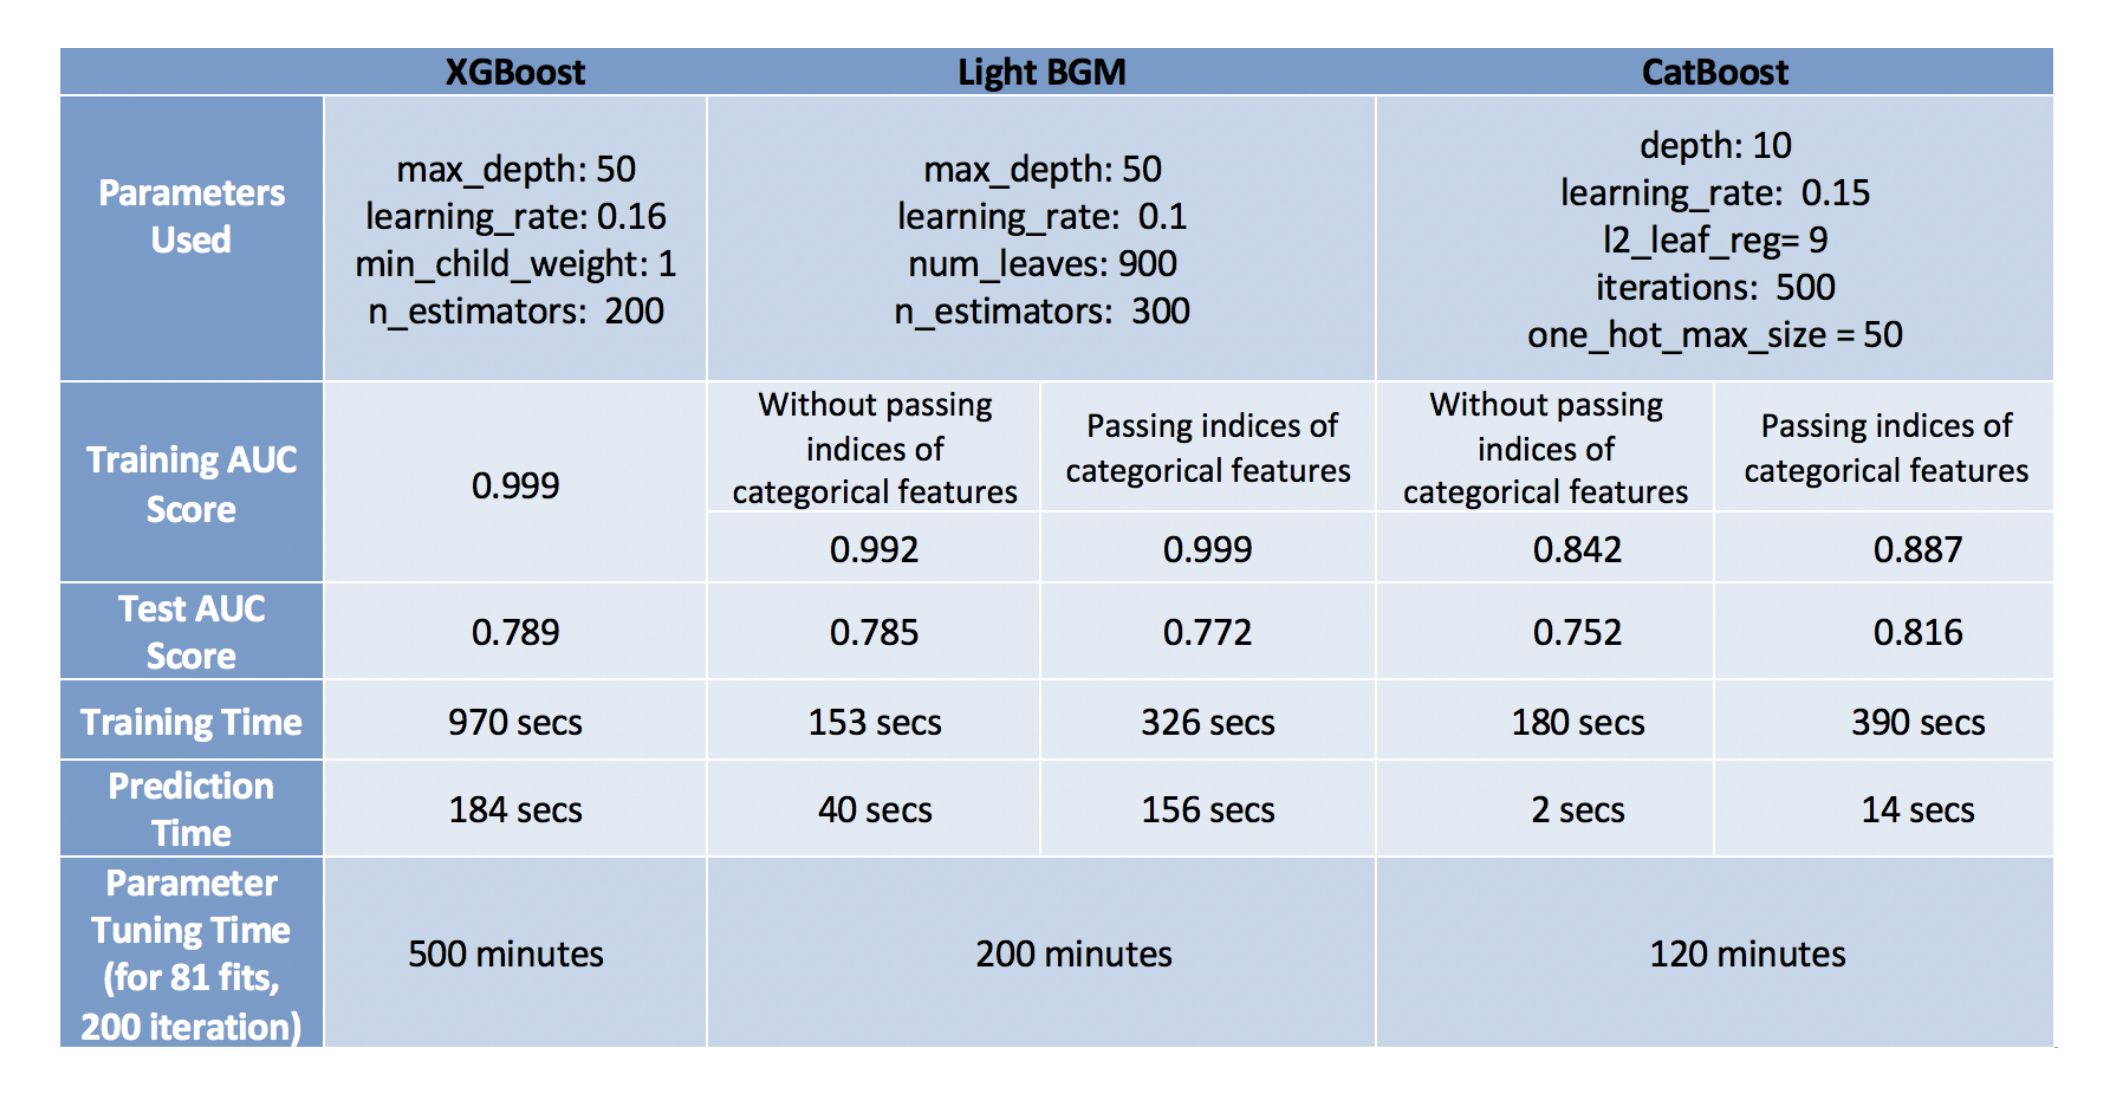

In [37]:
# With Categorical features
clf = cb.CatBoostClassifier(eval_metric="AUC",one_hot_max_size=31, \
                            depth=10, iterations= 10, l2_leaf_reg= 9, learning_rate= 0.15)
clf.fit(tr_x_cb,tr_y, cat_features= categorical_features_indices)
auc(clf, tr_x_cb, va_x_cb)

0:	total: 240ms	remaining: 2.16s
1:	total: 429ms	remaining: 1.72s
2:	total: 607ms	remaining: 1.42s
3:	total: 779ms	remaining: 1.17s
4:	total: 953ms	remaining: 953ms
5:	total: 1.13s	remaining: 753ms
6:	total: 1.3s	remaining: 556ms
7:	total: 1.46s	remaining: 364ms
8:	total: 1.62s	remaining: 180ms
9:	total: 1.76s	remaining: 0us


(0.9560787974325157, 0.9525898350018025)

In [38]:
accuracy_score(va_y, clf.predict_proba(va_x_cb)[:, 1] > .5)

0.8857713796337833

## Random Forest
* Numerical value만 허용
* Factor 처리하기
* Level의 처리에 민감함
  - 없던 Level이 있으면 안됨
* sparse input의 경우 성능이 잘 나오지 않을 수 있음

In [39]:
from sklearn.ensemble import RandomForestClassifier

### Data 합하기

In [40]:
_tmp_dt  = balanced_data
_tmp_dt = _tmp_dt.drop(['msno', 'transaction_date_first', 'transaction_date_last', 'registration_init_time', 'membership_expire_date_first', 'membership_expire_date_last', 'membership_expire_date_nunique', 'date_count'], axis = 1)

# https://stackoverflow.com/questions/36967666/transform-scipy-sparse-csr-to-pandas

for i, f in enumerate(_tmp_dt.columns): 
    if i in categorical_features_indices: 
        lbl = preprocessing.LabelEncoder()
        _tmp_dt[f] = lbl.fit_transform(_tmp_dt[f].astype('str')) # Gender의 경우에는 숫자와 문자가 섞여 있는 형태. str로 모두 바꾸어주어야 함
        #print(len(_tmp_dt[f]))
        onehot = preprocessing.OneHotEncoder() 
        tmp = onehot.fit_transform(np.array(_tmp_dt[f]).reshape(len(_tmp_dt[f]), 1)) # tmp는 결과물이 csr_matrix 이므로 이를 array로 바꾸어주어야 함
        #print(pd.DataFrame(tmp.toarray()).head())
        #print(tmp.shape)
        tmp1 = pd.DataFrame(tmp.toarray(), columns = [f.join('_' + str(x)) for x in enumerate(range(tmp.shape[1]))])
        _tmp_dt = _tmp_dt.join(tmp1)

_tmp_dt.fillna((-999), inplace=True)

# 서로 분리하기
tr_x_rf, va_x_rf, tr_y_rf, va_y_rf = train_test_split(_tmp_dt, y, train_size = 0.7, random_state = 1234)

rf = RandomForestClassifier(n_estimators = 10)
rf.fit(tr_x_rf, tr_y_rf)

y_pred_rf = rf.predict_proba(va_x_rf)
roc_auc_score(va_y_rf, y_pred_rf[:, 1])

/opt/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9989207245604399

## No onehot

In [41]:
_tmp_dt  = balanced_data
_tmp_dt = _tmp_dt.drop(['msno', 'transaction_date_first', 'transaction_date_last', 'registration_init_time', 'membership_expire_date_first', 'membership_expire_date_last', 'membership_expire_date_nunique', 'date_count'], axis = 1)
# https://stackoverflow.com/questions/36967666/transform-scipy-sparse-csr-to-pandas
for i, f in enumerate(_tmp_dt.columns): 
    if i in categorical_features_indices: 
        lbl = preprocessing.LabelEncoder()
        _tmp_dt[f] = lbl.fit_transform(_tmp_dt[f].astype('str')) # Gender의 경우에는 숫자와 문자가 섞여 있는 형태. str로 모두 바꾸어주어야 함
_tmp_dt.fillna((-999), inplace=True)
# 서로 분리하기
tr_x_rf, va_x_rf, tr_y_rf, va_y_rf = train_test_split(_tmp_dt, y, train_size = 0.7, random_state = 1234)

rf_1 = RandomForestClassifier()
rf_1.fit(tr_x_rf, tr_y_rf)

y_pred_rf_1 = rf_1.predict_proba(va_x_rf)
roc_auc_score(va_y, y_pred_rf_1[:, 1])

/opt/venv/lib/python3.6/site-packages/sklearn/model_selection/_split.py:2026: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


0.9524233252820573